## Encode chess position

In [1]:
import sys
sys.path.insert(1, "lib/")
from dataset_utils import nb_channels, encode_position, store_many_hdf5
from ScoreGetter import ScoreGetter, Engine

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import current_process

We load a dataset containing millions of unique chess position represented by the [FEN](https://fr.wikipedia.org/wiki/Notation_Forsyth-Edwards) notation.

In [2]:
df = pd.read_csv("/media/gaetan/HDD/IA/Chess/Datasets/fen_dataset.csv")
df = df.sample(frac=1)

We create our train/test dataset.

Each position is encoded as an image of $8\times8$ "pixels" with $16$ channels
($12$ representing each chess pieces, $2$ for black and  white player ($[1,0]$ if its
whites to play, $[0,1]$ otherwise), $1$
for the en-passant square and $1$ for the castling rights). Along this encoded position, we store
the score given by Leela Chess Zero.

In [3]:
score_getter = ScoreGetter("bin/lc0", Engine.LEELA)

nb_position = 500000
position = np.zeros((nb_position, 8, 8, nb_channels), dtype=np.float32)
scores = np.zeros(nb_position, dtype=np.float32)

# Status bar configuration
current = current_process()
pos = current._identity[0]-1 if len(current._identity) > 0 else 0
pbar = tqdm(total=nb_position, desc="Encoding", position=pos)

count = 0
for i in range(nb_position):
  pbar.update(1)
  fen = df["board"][i]
  try:
    scores[i] = score_getter.get_score(fen)
    position[i] = encode_position(fen)
    count += 1
  except Exception as e:
    if str(e) == "[Errno 32] Broken pipe":
        score_getter.restart()
    continue
scores = scores[:count]
position = position[:count]
print(f"Number of positions: {position.shape[0]}")

Encoding: 100%|█████████▉| 499992/500000 [1:34:08<00:00, 87.70it/s]

Number of positions: 497764


We look at the distribution of the scores

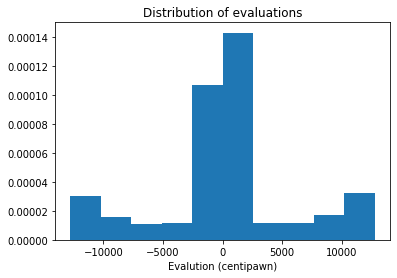

In [4]:
plt.hist(scores, density=True)
plt.xlabel("Evalution (centipawn)")
plt.title("Distribution of evaluations")
_ = plt.savefig("results/distribution.pdf")

In [5]:
pd.Series(scores).describe()

count    497764.000000
mean        128.670807
std        5653.637207
min      -12767.326172
25%        -209.924145
50%           8.148500
75%         369.171921
max       12767.326172
dtype: float64

We save the resulting dataset using HDF5.

In [6]:
directory = "/media/gaetan/HDD/IA/Chess/Datasets/SE_ResNet/"
store_many_hdf5(position, scores.reshape(-1, 1), directory, tag="_train")

Encoding: 100%|██████████| 500000/500000 [1:34:20<00:00, 87.70it/s]